<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/neural-network-classification/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with PyTorch

## Creating some dummy data

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [5]:
# creating a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


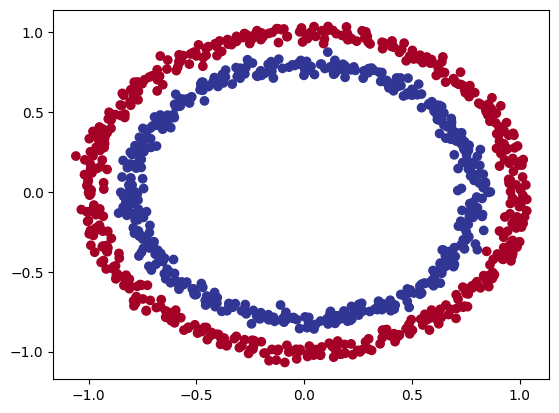

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

## Turn data into tensors

In [8]:
import torch

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

## Split data into train and test set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## Model Building

Steps fo modeling:

1. Device agnostic code.
2. Define model subclass.
3. Define a loss function and optimizer.
4. Create a training and test loop.

In [11]:
import torch
from torch import nn

In [12]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [13]:
# defining a model subclass
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)   # takes in two features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1)   # takes in five features and outputs a single features

  # forward pass
  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    return x

In [14]:
# initializing our model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
# replicating the model above using nn.Sequential()
model_0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6566,  0.1269],
                      [ 0.0924,  0.2843],
                      [-0.1880, -0.0353],
                      [-0.2167,  0.3032],
                      [-0.6806,  0.3532]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.5156,  0.2664,  0.3925,  0.5960, -0.3285], device='cuda:0')),
             ('layer_2.weight',
              tensor([[0.3394, 0.0510, 0.2702, 0.4128, 0.0606]], device='cuda:0')),
             ('layer_2.bias', tensor([0.0790], device='cuda:0'))])

In [18]:
model_0_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1084, -0.1894],
                      [-0.0604, -0.3119],
                      [ 0.6559, -0.1256],
                      [-0.1794,  0.3522],
                      [ 0.0395, -0.2319]], device='cuda:0')),
             ('0.bias',
              tensor([-0.5558,  0.0186,  0.1024,  0.4131,  0.5468], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4054, -0.3849, -0.0600,  0.2989,  0.3530]], device='cuda:0')),
             ('1.bias', tensor([-0.3889], device='cuda:0'))])

### Setting loss function and optimizer

In [19]:
# loss function
# loss_fn = nn.BCELoss()   # BCELoss() -> it reuires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()   # BCEWithLogitsLoss() -> Has sigmoid activation function built in

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Setting up evaluation matrics

In [20]:
# calculate accurcy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

### Defining training and testing loop

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# putting data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# training and testing loop
for epoch in range(1, epochs+1):
  model_0.train()

  # forward propagation
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))   # turn logits -> pred probs -> pred labels

  # calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train)   # nn.BCEWithLogitsLoss expects raw logits(output of a particular layer) as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  # optimizer step (gradient descent)
  optimizer.step()

  # testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the test loss / accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 10 | Loss: 0.70983, Acc: 50.00% | Test loss: 0.71383, Test acc: 50.00%
Epoch: 20 | Loss: 0.69923, Acc: 50.00% | Test loss: 0.70307, Test acc: 50.00%
Epoch: 30 | Loss: 0.69557, Acc: 56.12% | Test loss: 0.69907, Test acc: 55.00%
Epoch: 40 | Loss: 0.69421, Acc: 54.00% | Test loss: 0.69745, Test acc: 51.00%
Epoch: 50 | Loss: 0.69368, Acc: 52.62% | Test loss: 0.69673, Test acc: 50.00%
Epoch: 60 | Loss: 0.69344, Acc: 51.38% | Test loss: 0.69636, Test acc: 49.50%
Epoch: 70 | Loss: 0.69332, Acc: 51.75% | Test loss: 0.69616, Test acc: 47.50%
Epoch: 80 | Loss: 0.69325, Acc: 51.25% | Test loss: 0.69603, Test acc: 48.00%
Epoch: 90 | Loss: 0.69320, Acc: 51.00% | Test loss: 0.69593, Test acc: 48.50%
Epoch: 100 | Loss: 0.69317, Acc: 51.38% | Test loss: 0.69586, Test acc: 47.00%


### Making predictions and evalueating the model

In [22]:
import requests
from pathlib import Path

# download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


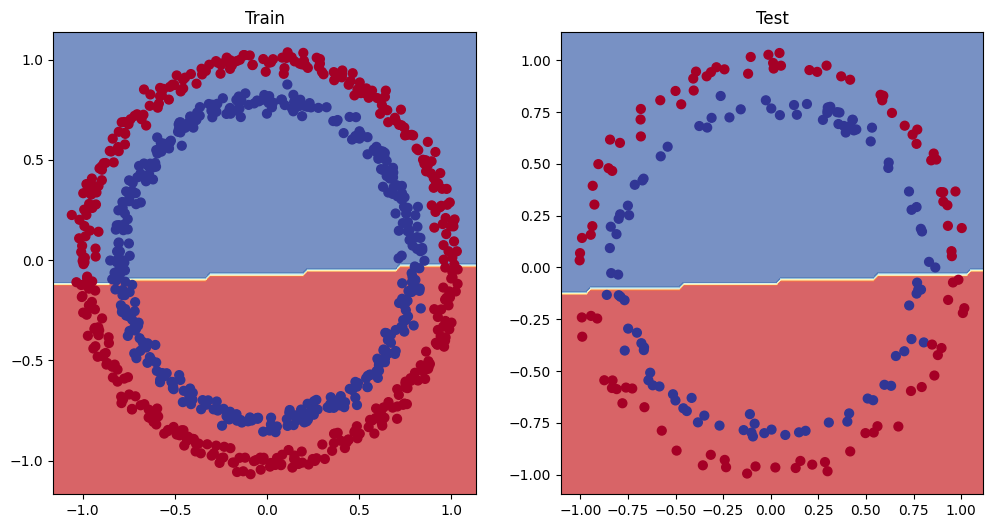

In [23]:
# plot the dicision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.show()

## Model Optimization

### Model with more hidden layers

In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return z

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# putting our data into the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(1, epochs):
  model_1.train()

  # forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss / accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (Gradient Descent)
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 100 | Loss: 0.69298, Acc: 51.50% | Test loss: 0.69469, Test acc: 45.50%
Epoch: 200 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69580, Test acc: 47.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


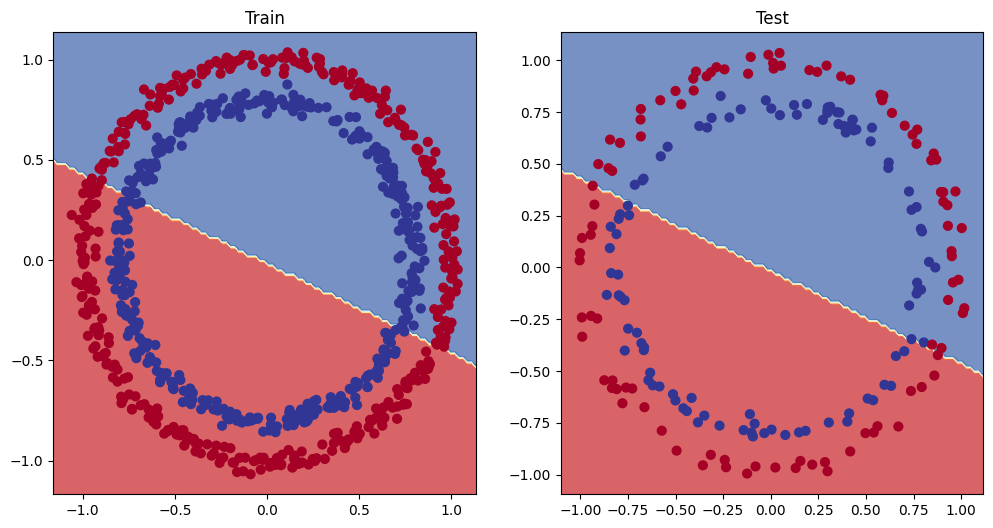

In [27]:
# plotting the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
plt.show()

## Introducing non-linearity to our model: The missing piece

The models that we have build so far are only capable of learning things by drawing a straight line through the dataset. But, the data we have been using for training our model is a non linear data (circular data).

So, it is not possible to learn patterns using straight lines any more. We must have to introduce some sort of capabiliies that the model can be able to fit non linear data.

In this case to introduce non linearity to our model, we can use non linear `Activation Functions`

In [37]:
class CircleModelNonLinear(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)
    return x

model_2 = CircleModelNonLinear().to(device)
model_2

CircleModelNonLinear(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [38]:
# setting optimizer and loss function
loss_fn = nn.BCEWithLogitsLoss()

# setting optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# putting all the data into the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# training and testing loop
for epoch in range(1, epochs+1):
  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calcualte the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # step the optimizer
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # printing whats happning
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .4f} | Training Acc: {acc: .4f}% | Test Loss: {test_loss: .4f} | Test Acc: {acc: .4f}%")

Epoch: 10 | Loss:  0.6872 | Training Acc:  52.8750% | Test Loss:  0.6850 | Test Acc:  52.8750%
Epoch: 20 | Loss:  0.6782 | Training Acc:  53.6250% | Test Loss:  0.6730 | Test Acc:  53.6250%
Epoch: 30 | Loss:  0.6628 | Training Acc:  60.0000% | Test Loss:  0.6552 | Test Acc:  60.0000%
Epoch: 40 | Loss:  0.6360 | Training Acc:  66.2500% | Test Loss:  0.6271 | Test Acc:  66.2500%
Epoch: 50 | Loss:  0.5911 | Training Acc:  74.7500% | Test Loss:  0.5820 | Test Acc:  74.7500%
Epoch: 60 | Loss:  0.5273 | Training Acc:  80.7500% | Test Loss:  0.5348 | Test Acc:  80.7500%
Epoch: 70 | Loss:  0.4448 | Training Acc:  89.8750% | Test Loss:  0.4634 | Test Acc:  89.8750%
Epoch: 80 | Loss:  0.3492 | Training Acc:  96.1250% | Test Loss:  0.3679 | Test Acc:  96.1250%
Epoch: 90 | Loss:  0.2566 | Training Acc:  98.5000% | Test Loss:  0.2806 | Test Acc:  98.5000%
Epoch: 100 | Loss:  0.1796 | Training Acc:  99.3750% | Test Loss:  0.2127 | Test Acc:  99.3750%


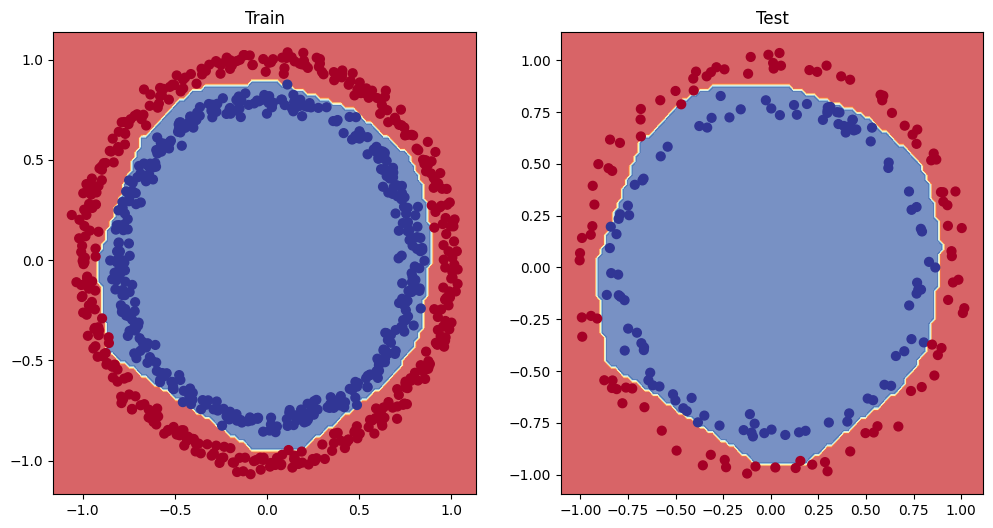

In [40]:
# plotting the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)
plt.show()